# Principais Bibliotecas

In [ ]:
pip install control

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import control as ctrl
import sympy
from sympy import *
init_printing()

# Funções Auxiliares

### Respostas ao Degrau e Impulso

Plota a resposta ao degrau discreta passando como parâmetros a planta discreta e o tempo de simulação.

In [ ]:
def step_z(sysz,T, figx=9, figy=4, te=0.02, ts = (0.1,0.9), Amp=1):
  xz, yz = ctrl.step_response(Amp*sysz, T)
  fig, ax = plt.subplots(figsize=(figx,figy))

  ax.step(xz, yz, where='post')
  ax.plot(xz, yz, 'C0o',alpha=0)
  S = step_info(xz, yz, te, ts, Amp)
  return S

Plota a resposta ao degrau discreta passando como parâmetros a planta discreta e o tempo de simulação.

In [ ]:
def impulse_z(Gz,T, figx=9, figy=4, Amp=1):
  xz, yz = ctrl.impulse_response(Amp*Gz, T)
  fig, ax = plt.subplots(figsize=(figx,figy))

  ax.step(xz, yz, where='post')
  ax.plot(xz, yz, 'C0o',alpha=0)

Plota a Resposta ao degrau Contínua e as diferentes respostas ao degrau discreto para funções de transferências discretizadas em diferentes Ts.

In [ ]:
def step_s_z(Gs, Gz, T, figx=9, figy=4, Amp=1):
  xs, ys = ctrl.step_response(Amp*Gs, T=T)
  fig, ax = plt.subplots(figsize=(figx,figy))
  deg_c = ax.plot(xs, ys, linewidth=1.5, label='Contínuo')
  if Gz !=None:
    for i in range(len(Gz)):
      plt.gca()
      xz, yz = ctrl.step_response(Amp*Gz[i], T)
      deg_z = ax.step(xz, yz, where='post', label = str(round(Gz[i].dt, 6)))
      plt.legend()

### Parâmetros de Desempenho

Calcula os parâmetros de desempenho ao step e retorna em formato de dicionário.

In [ ]:
def step_info(t, y, SettlingTimeThreshold, RiseTimeLimits, Amp):
  
  InfValue = y[-1]

  #RiseTime
  tr_lower_index = (np.where(y >= RiseTimeLimits[0] * InfValue)[0])[0]
  tr_upper_index = (np.where(y >= RiseTimeLimits[1] * InfValue)[0])[0]
  RiseTime = t[tr_upper_index] - t[tr_lower_index]

  # SettlingTime
  sup_margin = (1. + SettlingTimeThreshold) * InfValue
  inf_margin = (1. - SettlingTimeThreshold) * InfValue
  # find Steady State looking for the first point out of specified limits
  for i in reversed(range(t.size)):
      if((y[i] <= inf_margin) | (y[i] >= sup_margin)):
          SettlingTime = t[i + 1]
          break
  # Peak
  PeakIndex = np.abs(y).argmax()
  PeakValue = y[PeakIndex]
  PeakTime = t[PeakIndex]
  SettlingMax = (y).max()
  SettlingMin = (y[tr_upper_index:]).min()
  # I'm really not very confident about UnderShoot:
  UnderShoot = y.min()
  OverShoot = 100. * (y.max() - InfValue) / (InfValue - y[0])

  # Eest
  Eest = Amp-InfValue

  # Return as a dictionary
  S = {
      'Tempo de Subida': RiseTime,
      'Tempo de Estabilização': SettlingTime,
      #'SettlingMin': SettlingMin,
      #'SettlingMax': SettlingMax,
      'Overshoot(%)': OverShoot,
      #'Undershoot': UnderShoot,
      'Pico': PeakValue,
      'Tempo de Pico': PeakTime,
      'Valor de Estabilização': InfValue,
      'Erro Estacionário': Eest
    }

  return S

### PZMAP Discreto

Plota o mapa de pólos e zeros discreto com círculo de raio unitário, que demarca a região de estabilidade.

In [ ]:
def pzmap_z(syz):
  if ctrl.isdtime(syz):
    polos,zeros=ctrl.pzmap(syz, plot=True)
    ax = plt.gca()
    ax.add_patch(plt.Circle((0,0), radius=1.0,
                        linestyle=':', edgecolor='k', linewidth=1.5,
                        fill=False, zorder=-20))
    return polos, zeros
  else:
    print("Função Não Discretizada")

### Projeto de Controladores

Análogo a ferramenta sisotool do MATLAB, porém com a estrutura do controlador PD, com ganho e posição do zero ajustáveis.

In [ ]:
def sisotool_pd(c, k, sysz, Ts, T=10):
  Kz = ctrl.sample_system(ctrl.TransferFunction([1],[1]),Ts,'zoh')
  Kz.num = [[np.asarray([k*1, -c*k])]]
  Kz.den = [[np.asarray([1,0])]]

  Gz = sysz*Kz
  Tz = ctrl.feedback(Gz)
  polos, zeros = ctrl.root_locus(Gz, xlim=[-1.2,1.2], ylim=[-1.2,1.2], plot=True, print_gain=True,grid=False)
  S = step_z(Tz, T)
  return Kz, S

Análogo a ferramenta sisotool do MATLAB, porém com a estrutura do controlador PI, com ganho e posição do pólo ajustáveis.

In [ ]:
def sisotool_pi(c, k, sysz, Ts, T=10):

  Kz = ctrl.sample_system(ctrl.TransferFunction([1],[1]),Ts,'zoh')
  Kz.num = [[np.asarray([k*1, -c*k])]]
  Kz.den = [[np.asarray([1,-1])]]

  MA = sysz*Kz
  Tz = ctrl.feedback(MA)

  polos, zeros = ctrl.root_locus(MA, xlim=[-1.2,1.2], ylim=[-1.2,1.2], plot=True, print_gain=True,grid=False)
  S = step_z(Tz, T)
  return Kz, S

Análogo a ferramenta sisotool do MATLAB, porém com a estrutura do controlador PID, com ganho e posição dos zeros e pólos ajustáveis.

In [ ]:
def sisotool_pid(r,theta,k,sysz, Ts, T=10):
  B=2*r
  C= ((4*theta**2)+(B**2))/4

  Kz = ctrl.sample_system(ctrl.TransferFunction([1], [1]), Ts, 'zoh')
  knum = np.asarray([k, -1*B*k, C*k])
  kden = np.asarray([1, -1, 0])

  Kz.num = [[knum]]
  Kz.den = [[kden]]

  Gz = Kz*sysz
  Tz = ctrl.feedback(Gz)

  polos, zeros = ctrl.root_locus(Gz, xlim=[-1.2,1.2], ylim=[-1.2,1.2], plot=True, print_gain=True,grid=False)
  S = step_z(Tz, T)
  return Kz, S 

### Equação a Diferenças

Calcula a Equação a Diferenças a Partir da Função de Transferência Discreta até 6ª Ordem.

In [ ]:
def Eq_Dif(Kz):
  # Vetores para os termos que acompanhas ek_n e uk_m
  ek_c=[] 
  uk_c=[]
  # Cria os arrays com os termos
  num_array = Kz.num[0][0]
  den_array = Kz.den[0][0]
  if len(num_array) != 0:
    for i in range(len(num_array)):
      ek_c.append(num_array[i])
  if len(den_array) != 0:
    for i in range(len(den_array)):
      uk_c.append(den_array[i])
  # Variaveis simbólicas para mostrar a equação a Diferenças até 6ª Ordem
  ek, ek_1, ek_2, ek_3, ek_4, ek_5, ek_6 = symbols('ek, ek_1, ek_2, ek_3, ek_4, ek_5, ek_6')
  uk, uk_1, uk_2, uk_3, uk_4, uk_5, uk_6 = symbols('uk, uk_1, uk_2, uk_3, uk_4, uk_5, uk_6')
  # Completa os vetores até a 6ª Ordem
  aux=1
  while aux!=0:
    if len(ek_c) != 7:
      ek_c.append(0)
    if len(uk_c) != 7:
      uk_c.append(0)
    else:
      aux = 0
  # Arredonda em 4 casa decimais os termos de uk e ek
  ek_c = np.round(ek_c, 4)
  uk_c = np.round(uk_c, 4)
  # Escreve a Esquação a Diferenças e isola uk    
  EQ_D = Eq(uk*uk_c[0]+ uk_1*uk_c[1]+ uk_2*uk_c[2]+ uk_3*uk_c[3]+ uk_4*uk_c[4]+ uk_5*uk_c[5]+ uk_6*uk_c[6], 
            ek*ek_c[0]+ ek_1*ek_c[1]+ ek_2*ek_c[2]+ ek_3*ek_c[3]+ ek_4*ek_c[4]+ ek_5*ek_c[5]+ ek_6*ek_c[6])
  EQ_D1 = Eq(uk, solve(EQ_D, uk)[0])
  return EQ_D1

###Root Locus Ganho de Estabilidade Máximo


Plota o Gráfico Lugar das Raízes e calcula o ganho de estabilidade máxima em malha fechada.

In [ ]:
def root_locus_max_gain(Gz, kveck=np.arange(0, 100, 0.01)):
  roots, gain = ctrl.rlocus(Gz, kveck, xlim=(-1.1,1.1), ylim=(-1.1,1.1), grid=False, plot = False) 
  aux = roots.shape[1]
  #Descobre o valor de Kmax onde o modulo da 1
  kzeros = []
  ganhos = []
  for t in range(aux):
    for i in range(len(gain)):
      max = abs(roots[i,t])
      if max >= 1 and max < 1.001:    
        kzeros.append(round(roots[i,t],2))
        ganhos.append(round(gain[i],2))
        break
  #Plota o gráfico com um ponto e legenda no Kmax 
  raizes2, gain2 = ctrl.root_locus(Gz, xlim=[-1.2,1.2], ylim=[-1.2,1.2], plot=True, print_gain=True,grid=False)
  legenda = []
  for z in range(len(kzeros)):
    ax = plt.gca()
    kzero = kzeros[z]
    ganho = ganhos[z]
    if np.iscomplex(kzero):
      legenda.append(ax.scatter(kzero.real, kzero.imag, label="%s %s"%(kzero,ganho)))
    else:
      legenda.append(ax.scatter(kzero, 0, label="%s %s"%(kzero,ganho)))  
    plt.legend(handles=legenda)
  return kzeros,ganhos

# Sistemas Amostrados


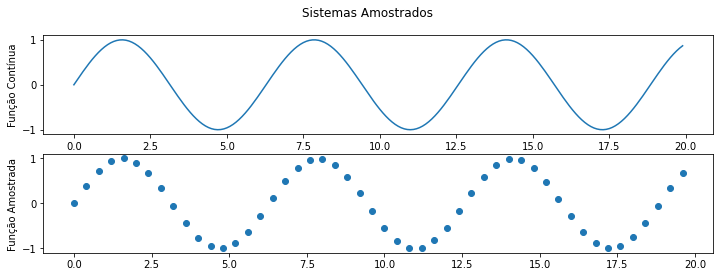

In [ ]:
Ts = 0.4 # variar esse valor 

t1 = np.arange(0, 20, 0.1)
t2 = np.arange(0,20,Ts)

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(12, 4))
fig.suptitle('Sistemas Amostrados')

ax2.plot(t2, np.sin(t2), 'o')
ax2.set_ylabel('Função Amostrada')

ax1.plot(t1, np.sin(t1), '-')
ax1.set_ylabel('Função Contínua')

plt.show()

# Mapeamento do Domínio "s" para o domínio "z"

A = 0+j0 \\
B = 0+j2 \\
C =-1+j2 \\
D =-1-j2 \\
E = 0,2-j2 \\
F = 0,2+j0 



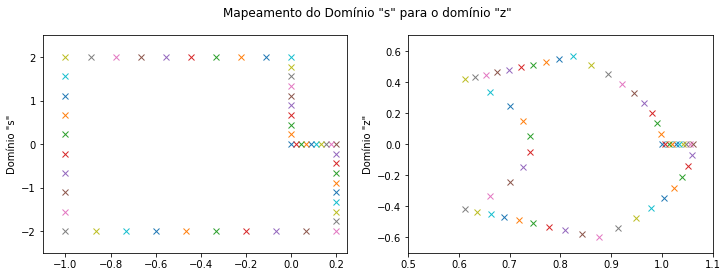

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle('Mapeamento do Domínio "s" para o domínio "z"')

# Período de amostragem
T = 0.3

# de A para B
sigma = 0
for w in np.arange(0,2,2/9):
	r  = exp(sigma*T)
	th = w*T
	# de polar para cartesiano
	a = r*cos(th)
	b = r*sin(th)
	# plotagens
	ax1.plot(sigma,w,'x')
	ax2.plot(a,b,'x')


# de B para C
w = 2
for sigma in np.arange(0,-1,-1/9):
	r  = exp(sigma*T)
	th = w*T
	# de polar para cartesiano
	a = r*cos(th)
	b = r*sin(th)
	# plotagens
	ax1.plot(sigma,w,'x')
	ax2.plot(a,b,'x')


# de C para D
sigma = -1
for w in np.arange(2,-2,-4/9): 
	r  = exp(sigma*T)
	th = w*T
	# de polar para cartesiano
	a = r*cos(th)
	b = r*sin(th)
	# plotagens
	ax1.plot(sigma,w,'x')
	ax2.plot(a,b,'x')


# de D para E
w = -2
for sigma in np.arange(-1,0.2,1.2/9):  
	r  = exp(sigma*T)
	th = w*T
	# de polar para cartesiano
	a = r*cos(th)
	b = r*sin(th)
	# plotagens
	ax1.plot(sigma,w,'x')
	ax2.plot(a,b,'x')


# de E para F
sigma = 0.2
for w in np.arange(-2,0,2/9):
	r  = exp(sigma*T)
	th = w*T
	# de polar para cartesiano
	a = r*cos(th)
	b = r*sin(th)
	# plotagens
	ax1.plot(sigma,w,'x')
	ax2.plot(a,b,'x')


# de F para A
w = 0
for sigma in np.arange(0.2,0,-0.2/9):
	r  = exp(sigma*T)
	th = w*T
	# de polar para cartesiano
	a = r*cos(th)
	b = r*sin(th)
	# plotagens
	ax1.plot(sigma,w,'x')
	ax2.plot(a,b,'x')

ax1.set_ylim(-2.5, 2.5)
ax1.set_xlim(-1.1, 0.25)

ax2.set_ylim(-0.7, 0.7)
ax2.set_xlim(0.5, 1.1)


ax1.set_ylabel('Domínio "s"')
ax2.set_ylabel('Domínio "z"')
plt.show()




# Funções de Transferências discretas

In [ ]:
num = [35]
den = [1,2,3]

Gz = ctrl.tf(num,den, dt = True)
Gz

TransferFunction(array([35]), array([1, 2, 3]), True)

In [ ]:
num = [35]
den = [1,2,3]
ts = 0.2
Gz = ctrl.tf(num,den,ts)
Gz

TransferFunction(array([35]), array([1, 2, 3]), 0.2)

# Discretização de Plantas Contínuas: Métodos ZOH e Tustin

### Parte Analítica ZOH
$$G(z)=\left( \frac{z-1}{z} \right) \mathcal{Z} \left\{ \mathcal{L}^{-1} \left\{ \frac{G(s)}{s} \right\}\right\}$$

Declarando a função contínua Gs

In [ ]:
s = symbols('s')
Gs = 2/(s+3)
Gs

Fazendo: $\frac{Gs}{s}$

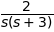

In [ ]:
r = Gs/s
r

Aplicando Frações Parciais na Variável $s$

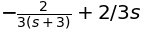

In [ ]:
r = apart(r,s)
r

Utilizando a tabela de equivalencias de "s" para "z" temos:

$$\frac{1}{s+a}=\frac{z}{z-e^{-aT}}$$

$$\frac{1}{s}=\frac{z}{z-1}$$

Logo a Eq acima fica:
$$\left(\frac{z-1}{z}\right) \frac{2}{3} \left[\frac{z}{z-1}-\frac{z}{z-e^{-3T}}\right]$$

Precisamos reescrever a função:

In [ ]:
z,T = symbols('z T')
r = ((z-1)/z)*2/3*(z/(z-1)-z/(z-exp(-3*T))) 
r

Simplificando a equação acima temos:

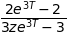

In [ ]:
Gz = simplify(r)
Gz

A simplificação foi feita, porém o comando simplify deixou o termo exponencial com potência positiva, quando desejávamos negativa.

Multiplicando numerador e denominador por $e^{-3T}$, obtemos

$$G(z)=\frac{2}{3}\frac{1-e^{-3T}}{z-e^{-3T}}$$

### Parte Computacional ZOH

In [ ]:
num = [2]
den = [1, 3]
Ts = 0.3
Gs = ctrl.tf(num,den)

Gz = ctrl.sample_system(Gs, Ts, method='zoh')
Gz

TransferFunction(array([0.39562023]), array([ 1.        , -0.40656966]), 0.3)

### Parte Analítica Tustin

Para aplicar o método de Tustin devemos substituir o "s" de Laplace por:
$s = \frac{2}{T} \frac{z-1}{z+1} $

Declarando a função Gs contínua

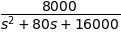

In [ ]:
s,z,T = symbols('s,z,T')
Gs = 8000/(s**2+80*s+16000)
Gs

Substituindo pelo s de Tustin

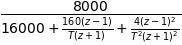

In [ ]:
a = Gs.subs(s,(2/T)*((z-1)/(z+1)))
a

Simplificando a equação acima temos:

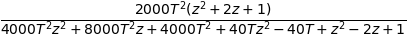

In [ ]:
r = expand(a)
r = simplify(r)
r

### Parte Computacional Tustin

In [ ]:
num = [8000]
den = [1, 80, 16000]
Ts = 0.3

Gs = ctrl.tf(num,den)
Gz = ctrl.sample_system(Gs, Ts, method='tustin')
Gz

TransferFunction(array([0.48257373, 0.96514745, 0.48257373]), array([1.        , 1.92493298, 0.93565684]), 0.3)

# Mapa de Pólos e Zeros Discreto

/usr/local/lib/python3.7/dist-packages/control/grid.py:152: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


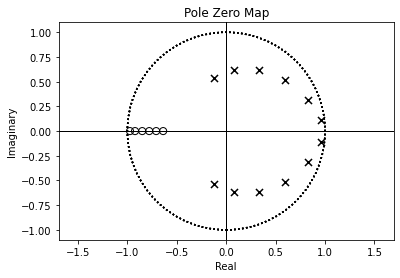

In [ ]:
Gs = ctrl.TransferFunction([800], [1, 80, 16000])
Ts = [0.001, 0.003, 0.006, 0.009, 0.012, 0.015]
Gz_list = []; polos_list=[]; zeros_list=[]
for t in Ts:
  Gz = ctrl.sample_system(Gs, t, method='zoh') 
  polos, zeros = pzmap_z(Gz)
  Gz_list.append(Gz); polos_list.append(polos); zeros_list.append(zeros)
plt.show()

In [ ]:
aux = 2
print(Gz_list[aux].dt, polos_list[aux], zeros_list[aux])

0.006 [0.59139133+0.51869035j 0.59139133-0.51869035j] [-0.84971891]


# Critérios de Estabilidade: Pólos e Jury

##Teste de Jury: Critérios 


> 1º Critério $$ |a_n| < a_0 $$





> 2º Critério $$ P(z)|_{z=1} > 0$$




> 3º Critério 

*   Para n par $$ P(z)|_{z=-1} > 0 $$
*   Para n ímpar $$ P(z)|_{z=-1} < 0 $$



> 4º Critério $$ |b_{n-1}| < |b_0| $$ $$ |c_{n-2}| < |c_0| $$ $$ |q_2| < |q_0| $$



















##Exemplo

In [ ]:
z = symbols('z')

# Atribuição dos coeficientes do polinômio
a0 = 1
a1 = -1.2
a2 = 0.07
a3 = 0.3
a4 = -0.08

Pz = a0*z**4 + a1*z**3 + a2*z**2 + a3*z + a4; Pz

###1º Critério

In [ ]:
print("|",a4,"| < ",a0,'=', abs(a4) < a0 )

| -0.08 | <  1 = True


### 2ºCritério

In [ ]:
r = Pz.subs(z,1);
print(r," > 0 =",r>0)

0.0900000000000001  > 0 = True


### 3ºCritério

In [ ]:
r = Pz.subs(z,-1)
print(r," > 0 =", r>0)

1.89000000000000  > 0 = True


### 4º Critério

In [ ]:
# Montagem da tabela de Jury
# Iniciando pelas duas primeiras linhas
M = Matrix([[a0,a1,a2,a3,a4],
            [a4,a3,a2,a1,a0]])
M

⎡  1    -1.2  0.07  0.3   -0.08⎤
⎢                              ⎥
⎣-0.08  0.3   0.07  -1.2    1  ⎦

In [ ]:
#Calulando B3
M2 = Matrix([[a4,a0],
             [a0,a4]])
display(M2)
b3=det(M2)
print("b3 =",b3)

⎡-0.08    1  ⎤
⎢            ⎥
⎣  1    -0.08⎦

b3 = -0.993600000000000


In [ ]:
#Calulando B2
M2 = Matrix([[a4,a1],
             [a0,a3]])
display(M2)
b2=det(M2)
print("b2 =",b2)

⎡-0.08  -1.2⎤
⎢           ⎥
⎣  1    0.3 ⎦

b2 = 1.17600000000000


In [ ]:
#Calulando B1
M2 = Matrix([[a4,a2],
             [a0,a2]])
display(M2)
b1=det(M2)
print("b1 =",b1)

⎡-0.08  0.07⎤
⎢           ⎥
⎣  1    0.07⎦

b1 = -0.0756000000000000


In [ ]:
#Calulando B0
M2 = Matrix([[a4,a3],
             [a0,a1]])
display(M2)
b0=det(M2)
print("b0 =",b0)

⎡-0.08  0.3 ⎤
⎢           ⎥
⎣  1    -1.2⎦

b0 = -0.204000000000000


In [ ]:
#Quarto Critério em b
#O módulo de b0 tem que ser menor que o módulo de b3
print("|",b0,"| <",'|',b3,'|','=', abs(b0) < abs(b3) )

| -0.204000000000000 | < | -0.993600000000000 | = True


In [ ]:
#Linhas centrais 
M = Matrix([[b3,b2,b1,b0],
            [b0,b1,b2,b3]])
M

⎡-0.9936   1.176   -0.0756  -0.204 ⎤
⎢                                  ⎥
⎣-0.204   -0.0756   1.176   -0.9936⎦

In [ ]:
#Calulando C2
M2 = Matrix([[b3,b0],
             [b0,b3]])
display(M2)
c2=det(M2)
print("c2 =",c2)

⎡-0.9936  -0.204 ⎤
⎢                ⎥
⎣-0.204   -0.9936⎦

c2 = 0.945624960000000


In [ ]:
#Calulando C1
M2 = Matrix([[b3,b1],
             [b0,b2]])
display(M2)
c1=det(M2)
print("c1 =",c1)

⎡-0.9936  -0.0756⎤
⎢                ⎥
⎣-0.204    1.176 ⎦

c1 = -1.18389600000000


In [ ]:
#Calulando C0
M2 = Matrix([[b3,b2],
             [b0,b1]])
display(M2)
c0=det(M2)
print("c0 =",c0)

⎡-0.9936   1.176 ⎤
⎢                ⎥
⎣-0.204   -0.0756⎦

c0 = 0.315020160000000


In [ ]:
#Quarto Critério em c
#O módulo de c0 tem que ser menor que o módulo de c2
print("|",c0,"| <",'|',c2,'|','=', abs(c0) < abs(c2) )

| 0.315020160000000 | < | 0.945624960000000 | = True


Como todas as condições foram cumpridas, pode-se dizer que o sistema tem todas as raizes dentro do circulo unitário sendo estável

### Utilizando a função Solve
Também é possivel descobrir as raizes do polinômio com a função solve() e verificar se as raizes estão dentro do circuilo unitário

In [ ]:
solve(Pz,z)

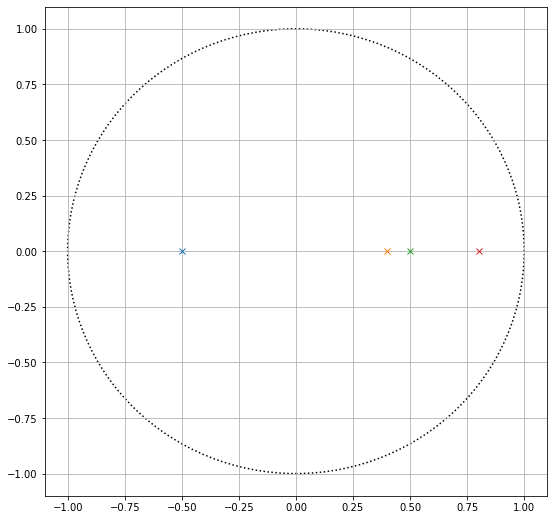

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
ax.add_patch(plt.Circle((0,0), radius=1.0,
                        linestyle=':', edgecolor='k', linewidth=1.5,
                        fill=False, zorder=-20))
ax.plot(-0.5, 0, 'x')
ax.plot(0.4, 0, 'x')
ax.plot(0.5, 0, 'x')
ax.plot(0.8, 0, 'x')
ax.grid(True)

# Resposta ao Degrau e Impulse Discreto

In [ ]:
num = [10]
den = [1, 5, 10]
Gs = ctrl.TransferFunction(num, den)
Gs

TransferFunction(array([10]), array([ 1,  5, 10]))

{'Erro Estacionário': 2.09205985868266e-11,
 'Overshoot(%)': 1.7277241887834822,
 'Pico': 1.0172772418665528,
 'Tempo de Estabilização': 1.2000000000000002,
 'Tempo de Pico': 1.6,
 'Tempo de Subida': 0.8,
 'Valor de Estabilização': 0.9999999999790794}

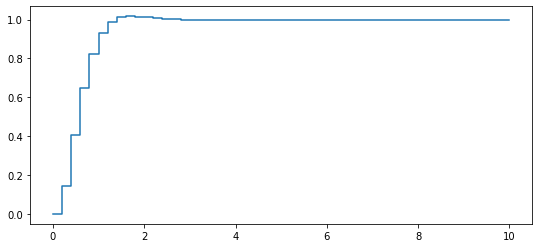

In [ ]:
Gz = ctrl.sample_system(Gs, 0.2, 'zoh')
S = step_z(Gz, 10, ts=(0.1,0.9))
S

In [ ]:
Ts = [0.2, 0.5, 1]
Gz = ctrl.sample_system(Gs, Ts[0], 'zoh')
Gz1 = ctrl.sample_system(Gs, Ts[1], 'zoh')
Gz2 = ctrl.sample_system(Gs, Ts[2], 'zoh')

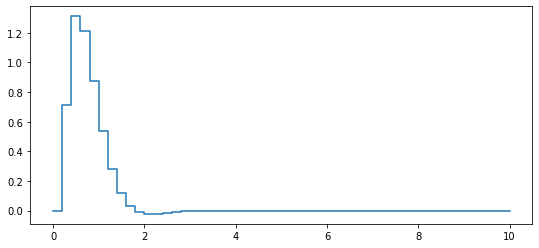

In [ ]:
impulse_z(Gz, 10)

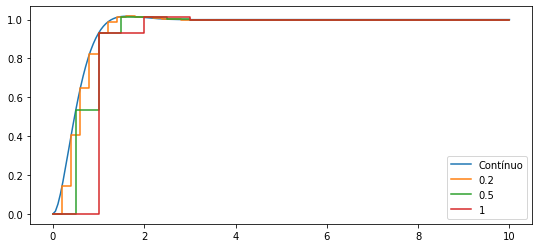

In [ ]:
step_s_z(Gs,[Gz, Gz1, Gz2], 10)

# Método Lugar das Raízes Discreto

## Método RLOCUS

In [ ]:
num = [5]
den = [1, 2]
Gs = ctrl.TransferFunction(num, den)
Gs

TransferFunction(array([5]), array([1, 2]))

In [ ]:
Gz_list = []
Ts_list = [0.1, 0.05, 0.02]
for t in Ts_list:
  Gz = ctrl.sample_system(Gs, t)
  Gz_list.append(Gz)

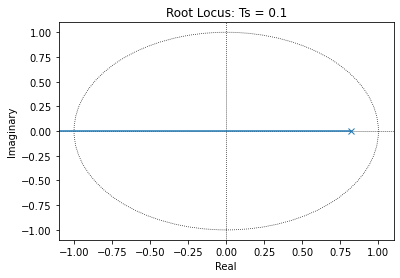

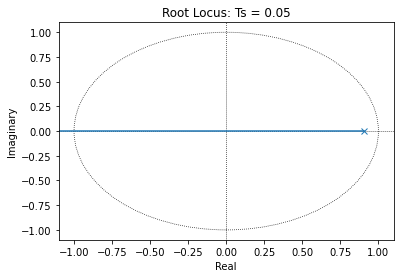

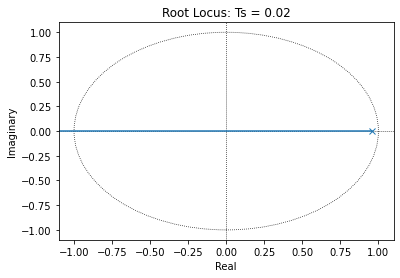

In [ ]:
kveck = np.arange(0, 100, 0.01)
for G in Gz_list:
  roots, gain = ctrl.rlocus(G, kveck, print_gain=True, xlim=(-1.1,1.1), ylim=(-1.1,1.1), grid=False, plot = True)
  plt.title('Root Locus: Ts = ' + str(G.dt))
  plt.show()

## Ganho de Estabilidade Máximo

In [ ]:
num = [1.5]
den = [1, 4, 3, 0]
Gs = ctrl.TransferFunction(num, den)
Gs

TransferFunction(array([1.5]), array([1, 4, 3, 0]))

In [ ]:
Gz_list = []
Ts_list = [1, 0.6, 0.2]
for t in Ts_list:
  Gz = ctrl.sample_system(Gs, t)
  Gz_list.append(Gz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


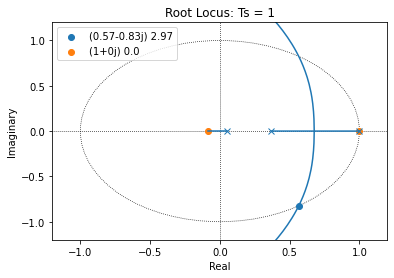

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  # This is added back by InteractiveShellApp.init_path()


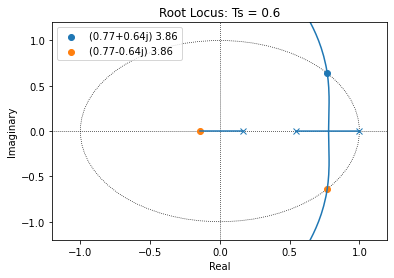

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  # This is added back by InteractiveShellApp.init_path()


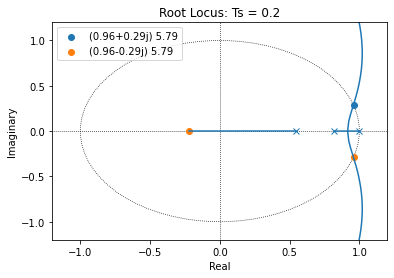

In [ ]:
for G in Gz_list:
  kzeros,ganhos = root_locus_max_gain(G)
  plt.title('Root Locus: Ts = ' + str(G.dt))
  plt.show() 

# Estrutura de Controladores Discretos


Controlador PD:


*   1 zero real ajustável.
*   1 polo real fixo em 0.



$C_{PD}(z) = \frac{(kp+kd)z - kd}{z}$



In [ ]:
kp = 1
kd = 5
CPDz = ctrl.TransferFunction([kp+kd, -kd], [1,0], dt=True)
CPDz

TransferFunction(array([ 6, -5]), array([1, 0]), True)

(array([0.]), array([0.83333333]))

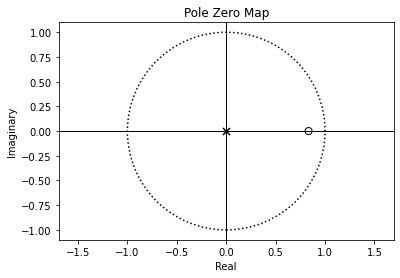

In [ ]:
polos, zeros=pzmap_z(CPDz)
polos, zeros

Controlador PI:



*  1 zero real ajustável.
*  1 pólo fixo em 1.


$C_{PI}(z) = \frac{(kp+ki)z - kp}{z-1}$

In [ ]:
kp = 1
ki = 5
CPIz = ctrl.TransferFunction([kp+ki, -kd], [1,-1], dt=True)
CPIz

TransferFunction(array([ 6, -5]), array([ 1, -1]), True)

(array([1.]), array([0.83333333]))

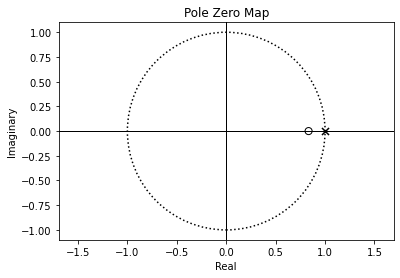

In [ ]:
polos, zeros=pzmap_z(CPIz)
polos, zeros

Controlador PID:


*   1 pólo real fixo em 0.
*   1 pólo real fixo em 1.
*   2 zeros complexos conjugados ajustáveis.



$C_{PID}(z) = \frac{(kp+kd+ki)z^2-(kp+kd)z+kd}{z(z-1)}$

In [ ]:
kp = 5
ki = 0.5
kd = 2
CPIDz = ctrl.TransferFunction([kp+ki+kd, -(kd+2*kd), kd], [1,-1, 0], dt=True)
CPIDz

TransferFunction(array([ 7.5, -6. ,  2. ]), array([ 1, -1,  0]), True)

(array([1., 0.]), array([0.4+0.32659863j, 0.4-0.32659863j]))

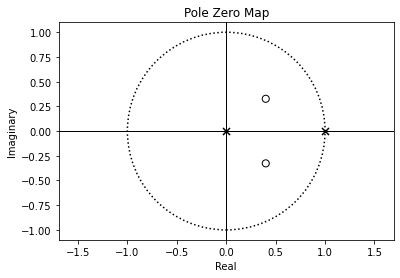

In [ ]:
polos, zeros=pzmap_z(CPIDz)
polos, zeros

# Projeto de Controladores Discretos 

Planta para os Projetos de Controle

In [ ]:
num = [80]
den = [0.89, 1]
Gs = ctrl.TransferFunction(num, den)
Gs

TransferFunction(array([80]), array([0.89, 1.  ]))

In [ ]:
Ts = 0.1
Gz = ctrl.sample_system(Gs, Ts, 'zoh')
Gz

TransferFunction(array([8.50217111]), array([ 1.        , -0.89372286]), 0.1)

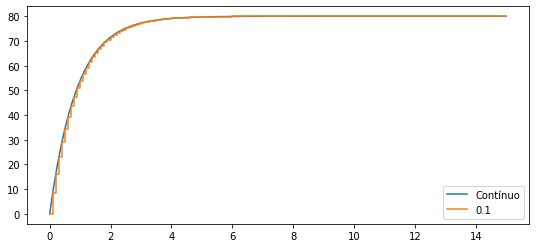

In [ ]:
step_s_z(Gs, [Gz], 15)

{'Erro Estacionário': -78.99894469813131,
 'Overshoot(%)': 0.0,
 'Pico': 79.99894469813131,
 'Tempo de Estabilização': 3.5,
 'Tempo de Pico': 10.0,
 'Tempo de Subida': 2.0,
 'Valor de Estabilização': 79.99894469813131}

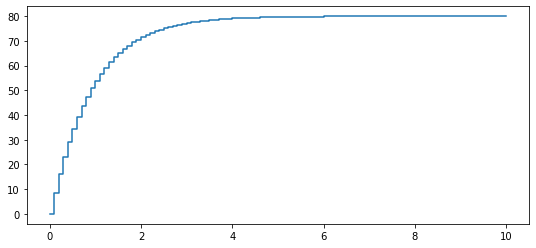

In [ ]:
step_z(Gz, 10)

array([0.89372286])

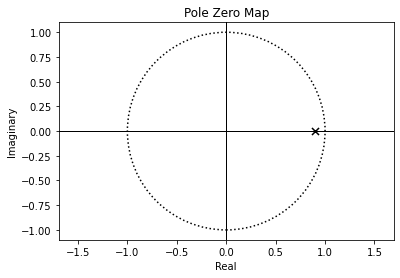

In [ ]:
polos, zeros = pzmap_z(Gz)
polos

### Projeto PD:
Requisitos: Overshoot < 5%; Te < 2 s.

{'Erro Estacionário': 0.53191494189132,
 'Overshoot(%)': 0.0,
 'Pico': 0.46808505810868,
 'Tempo de Estabilização': 1.9000000000000001,
 'Tempo de Pico': 10.0,
 'Tempo de Subida': 0.0,
 'Valor de Estabilização': 0.46808505810868}

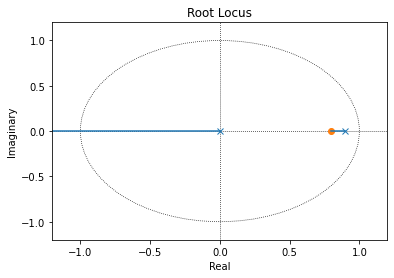

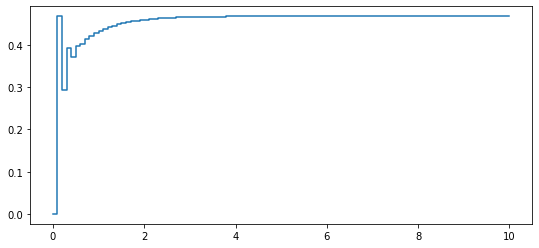

In [ ]:
Kz, S = sisotool_pd(0.8, 0.055, Gz, Ts)
S

### Projeto PI:
Requisitos: Overshoot < 5%; Te < 2 s

{'Erro Estacionário': 3.587619090694716e-11,
 'Overshoot(%)': 4.464558490559078,
 'Pico': 1.0446455848681129,
 'Tempo de Estabilização': 1.8,
 'Tempo de Pico': 1.0,
 'Tempo de Subida': 0.4,
 'Valor de Estabilização': 0.9999999999641238}

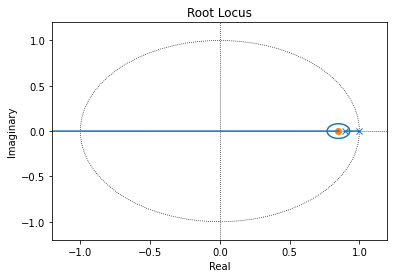

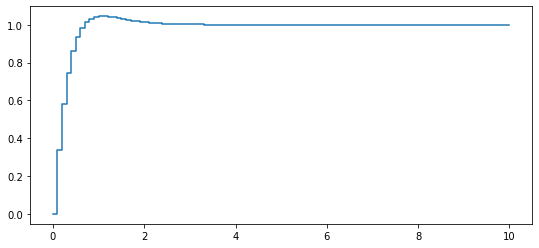

In [ ]:
Kz, S = sisotool_pi(0.85, 0.04, Gz, Ts)
S

### Projeto PID:
Requisitos: Overshoot < 5%; Te < 2.0 s

{'Erro Estacionário': 4.460519874904811e-06,
 'Overshoot(%)': 1.4088789342608707,
 'Pico': 1.014084265979409,
 'Tempo de Estabilização': 1.9000000000000001,
 'Tempo de Pico': 2.7,
 'Tempo de Subida': 0.0,
 'Valor de Estabilização': 0.9999955394801251}

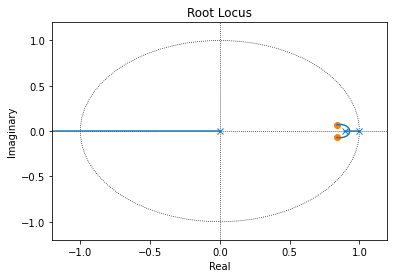

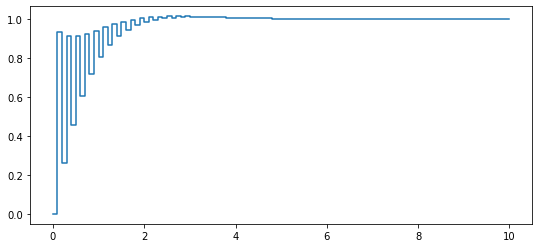

In [ ]:
Kz, S = sisotool_pid(0.84, 0.07, 0.11, Gz, Ts)
S

# Equações a Diferenças

In [ ]:
Kz

TransferFunction(array([ 0.11    , -0.1848  ,  0.078155]), array([ 1, -1,  0]), 0.1)

In [ ]:
Eq_Dif(Kz)

# Projeto Exemplo: Motor DC


### Função de Transferência Contínua

In [ ]:
La = 0.35
Ra = 1.5
Va = 220
kt = 0.5 
kv = 13
Jm = 0.01
Bm = 0.1
Jl = 0.04
Bl = 0.3
J = Jm + Jl
B = Bm + Bl

In [ ]:
num_motor = [kt]
den_motor = [La*J, (La*B)+(Ra*J), (Ra*B)+(kv*kt)]
Gs = ctrl.TransferFunction(num_motor, den_motor)
Gs

TransferFunction(array([0.5]), array([0.0175, 0.215 , 7.1   ]))

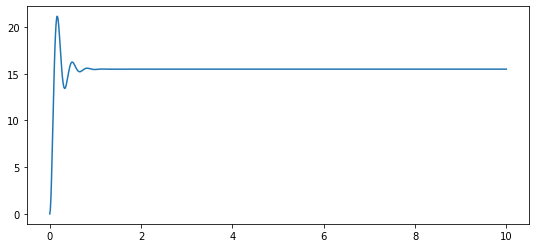

In [ ]:
step_s_z(Gs, None, 10, Amp=220)

### Função de Transferência Discreta com fs = 10 kHz

In [ ]:
Ts_10KHz = 1/10e3
Gz_10KHz = ctrl.sample_system(Gs, Ts_10KHz, 'zoh')
Gz_10KHz

TransferFunction(array([1.42798610e-07, 1.42740141e-07]), array([ 1.        , -1.99876813,  0.99877218]), 0.0001)

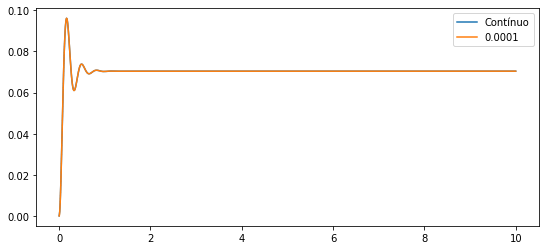

In [ ]:
step_s_z(Gs, [Gz_10KHz], 10)

### LR discreto e Ganho de Estabilidade Máximo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  # This is added back by InteractiveShellApp.init_path()


([(1-0.05j), (1+0.05j)], [8602, 8602])

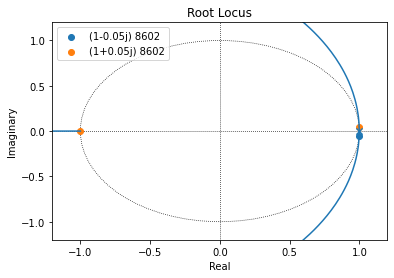

In [ ]:
kzero,ganho = root_locus_max_gain(Gz_10KHz, kveck = np.arange(0,10000, 1))
kzero, ganho

### MA ao degrau de entrada Va = 220 e Tempo de Subida (0 - 100 %).

{'Erro Estacionário': 204.50704225751755,
 'Overshoot(%)': 36.56698683557174,
 'Pico': 21.158265560616705,
 'Tempo de Estabilização': 0.557,
 'Tempo de Pico': 0.1638,
 'Tempo de Subida': 0.0981,
 'Valor de Estabilização': 15.492957742482453}

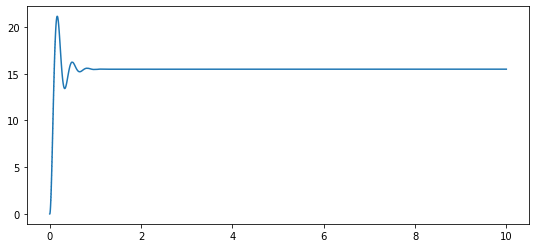

In [ ]:
S = step_z(Gz_10KHz, T=10, ts=(0,1), Amp=Va)
S

### Projeto do PI 10 kHZ


*   Overshoot < 2%
*   Tac = 8*Tr



In [ ]:
8*S['Tempo de Subida']

In [ ]:
Gz_10KHz.pole()

array([0.99938406+0.0019171j, 0.99938406-0.0019171j])

(array([0.99938406+0.0019171j, 0.99938406-0.0019171j]), array([-0.99959055]))

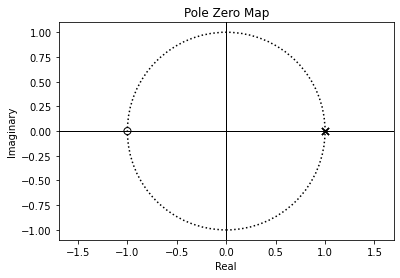

In [ ]:
pzmap_z(Gz_10KHz)

{'Erro Estacionário': 8.048472488475511e-08,
 'Overshoot(%)': 0.6168913410807624,
 'Pico': 1.0061688324295794,
 'Tempo de Estabilização': 0.7819,
 'Tempo de Pico': 0.36910000000000004,
 'Tempo de Subida': 0.0779,
 'Valor de Estabilização': 0.9999999195152751}

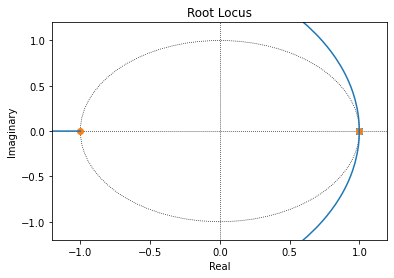

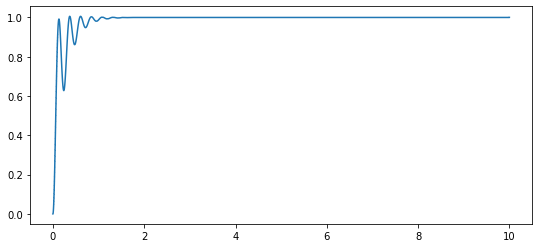

In [ ]:
K_PI_10KHz, S_PI_10KHz = sisotool_pi(0.9991, 12, Gz_10KHz, Ts_10KHz)
S_PI_10KHz

### Projeto do PI 100 HZ


*   Overshoot < 2%
*   Tac = 8*Tr



In [ ]:
Ts_100Hz = 1/100
Gz_100Hz = ctrl.sample_system(Gs, Ts_100Hz, 'zoh')
Gz_100Hz

TransferFunction(array([0.00136723, 0.0013123 ]), array([ 1.        , -1.84634068,  0.88438999]), 0.01)

In [ ]:
8*S['Tempo de Subida']

In [ ]:
Gz_100Hz.pole()

array([0.92317034+0.1792945j, 0.92317034-0.1792945j])

(array([0.92317034+0.1792945j, 0.92317034-0.1792945j]), array([-0.95982601]))

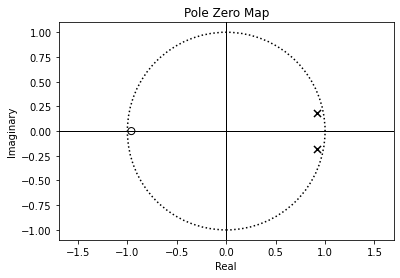

In [ ]:
pzmap_z(Gz_100Hz)

{'Erro Estacionário': -1.9895196601282805e-13,
 'Overshoot(%)': 0.6123526772289115,
 'Pico': 1.0061235267724893,
 'Tempo de Estabilização': 0.73,
 'Tempo de Pico': 0.8,
 'Tempo de Subida': 0.37,
 'Valor de Estabilização': 1.000000000000199}

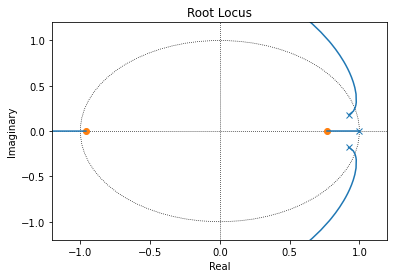

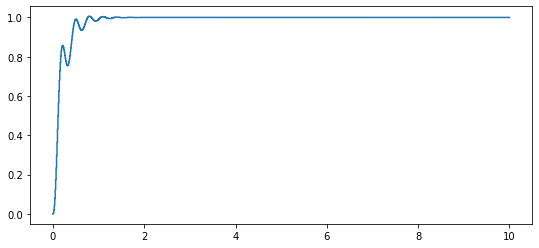

In [ ]:
K_PI_100Hz, S_PI_100Hz = sisotool_pi(0.77, 3.5, Gz_100Hz, Ts_100Hz)
S_PI_100Hz

In [ ]:
K_PI_100Hz

TransferFunction(array([ 3.5  , -2.695]), array([ 1, -1]), 0.01)

In [ ]:
kp_PI_100Hz = -K_PI_100Hz.num[0][0][1]
ki_PI_100Hz = kp_PI_100Hz - K_PI_100Hz.num[0][0][1] 
kp_PI_100Hz,ki_PI_100Hz

### Projeto do PID 100 HZ


*   Overshoot < 2%
*   Tac = 4*Tr



In [ ]:
4*S['Tempo de Subida']

In [ ]:
Gz_100Hz.pole()

array([0.92317034+0.1792945j, 0.92317034-0.1792945j])

{'Erro Estacionário': -7.149836278586008e-14,
 'Overshoot(%)': 0.05292700605079203,
 'Pico': 1.0005292700605795,
 'Tempo de Estabilização': 0.38,
 'Tempo de Pico': 0.6900000000000001,
 'Tempo de Subida': 0.29,
 'Valor de Estabilização': 1.0000000000000715}

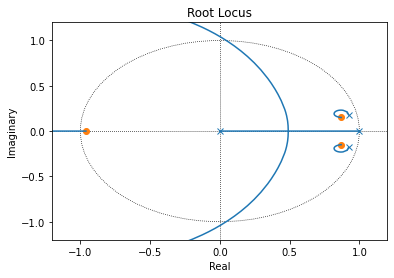

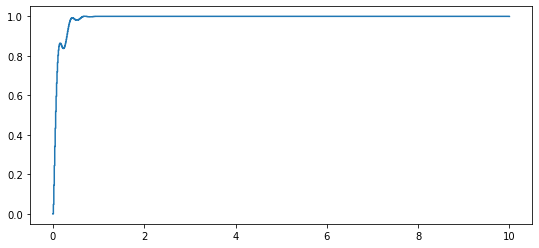

In [ ]:
K_PID_100Hz, S_PID_100Hz = sisotool_pid(0.87, 0.15, 35.2, Gz_100Hz, Ts_100Hz)
S_PID_100Hz

In [ ]:
K_PID_100Hz

TransferFunction(array([ 35.2    , -61.248  ,  27.43488]), array([ 1, -1,  0]), 0.01)

In [ ]:
kd_PID_100Hz = K_PID_100Hz.num[0][0][2]
kp_PID_100Hz = -K_PID_100Hz.num[0][0][1] - 2*kd_PID_100Hz 
ki_PID_100Hz = K_PID_100Hz.num[0][0][0] - (kp_PID_100Hz + kd_PID_100Hz) 
kp_PID_100Hz,ki_PID_100Hz, kd_PID_100Hz

### Equação a Diferenças dos controladores

In [ ]:
#PI - 10 KHz
print(K_PI_10KHz)
Eq_Dif(K_PI_10KHz)


12 z - 11.99
------------
   z - 1

dt = 0.0001



In [ ]:
#PI - 100 Hz
print(K_PI_100Hz)
Eq_Dif(K_PI_100Hz)


3.5 z - 2.695
-------------
    z - 1

dt = 0.01



In [ ]:
#PID - 100 Hz
print(K_PID_100Hz)
Eq_Dif(K_PID_100Hz)


35.2 z^2 - 61.25 z + 27.43
--------------------------
         z^2 - z

dt = 0.01

